In [1]:
import compiler_gym
import gym
import pandas as pd
import torch
from compiler_gym import CompilerEnv
from tabulate import tabulate
from tqdm import tqdm

from config.config import TrainConfig
from env.cfg_grind import compile_and_get_instructions
from runtime_eval.eval import measure_execution_mean_and_std
from utils import (
    get_agent,
    get_model_path,
    optimize_with_model,
)
from config.action_config import *

import matplotlib.pyplot as plt
import numpy as np

MODEL_ITERS = 10
RUNTIME_COUNT = 30
BIN_NAME = "tmp_o3_cbench_test_cfg_grind_bin"
RUN_TIME = "daily-capybara-88"

In [3]:
env = gym.make("llvm-v0")
benchmarks = list(env.datasets["benchmark://cbench-v1"].benchmarks())

In [4]:
config = TrainConfig()
config.algorithm = "LstmDQN"
config.fc_dim = 128
config.lstm_hiddem_size = 256
config.actions = COMPLETE_ACTION_SET
config.observation_space = "InstCountNorm"
config.observation_size = 69

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# agent = get_agent(
#     config,
#     device,
#     policy_net_path="/home/flint/diplom/experiments/" + get_model_path(RUN_TIME),
# )

In [5]:
math_benchs = {
    "qsort",
    "stringsearch",
    "susan",
    "tiff2bw",
    "tiff2rgba",
    "tiffdither",
    "tiffmedian",
}

In [6]:
results = {}

In [7]:
for benchmark in benchmarks:
    benchmark_name = str(benchmark).split('/')[-1]
    print(benchmark_name)
    results[benchmark_name] = []
    with compiler_gym.make("llvm-v0", benchmark=benchmark) as new_env:
        new_env.reset()
        if not new_env.observation["IsRunnable"]:
            print(f"Benchmark {benchmark} not runnable, skip it")
            continue

        try:
            benchmark.validate(new_env)
        except Exception as e:
            benchmark_args = e.msg.split(".bc")[-1].strip()
            cg_working_dir = e.dir

        linkopts = (
            ["-lm"]
            if str(benchmark).rsplit("/", maxsplit=1)[-1] in math_benchs
            else []
        )

        new_env.reset()
        for i in tqdm(range(len(O3_SEQ) + 1)):
            instructions_number = compile_and_get_instructions(
                ir=new_env.observation["Ir"],
                sequence=O3_SEQ[:i],
                result_path=BIN_NAME,
                execution_args=benchmark_args,
                linkopts=linkopts,
            )
            results[benchmark_name].append(instructions_number)
        

adpcm
Benchmark benchmark://cbench-v1/adpcm not runnable, skip it
bitcount


100%|█████████████████████████████████████████| 279/279 [07:52<00:00,  1.69s/it]


blowfish


100%|█████████████████████████████████████████| 279/279 [07:32<00:00,  1.62s/it]


bzip2


100%|█████████████████████████████████████████| 279/279 [18:01<00:00,  3.88s/it]


crc32


100%|█████████████████████████████████████████| 279/279 [04:05<00:00,  1.14it/s]


dijkstra


100%|█████████████████████████████████████████| 279/279 [04:10<00:00,  1.11it/s]


ghostscript
Benchmark benchmark://cbench-v1/ghostscript not runnable, skip it
gsm


100%|█████████████████████████████████████████| 279/279 [07:46<00:00,  1.67s/it]


ispell
Benchmark benchmark://cbench-v1/ispell not runnable, skip it
jpeg-c


100%|█████████████████████████████████████████| 279/279 [16:20<00:00,  3.51s/it]


jpeg-d


100%|█████████████████████████████████████████| 279/279 [15:49<00:00,  3.40s/it]


lame
Benchmark benchmark://cbench-v1/lame not runnable, skip it
patricia


100%|█████████████████████████████████████████| 279/279 [04:44<00:00,  1.02s/it]


qsort


100%|█████████████████████████████████████████| 279/279 [10:26<00:00,  2.24s/it]


rijndael
Benchmark benchmark://cbench-v1/rijndael not runnable, skip it
sha


100%|█████████████████████████████████████████| 279/279 [04:21<00:00,  1.07it/s]


stringsearch


100%|█████████████████████████████████████████| 279/279 [04:48<00:00,  1.04s/it]


stringsearch2


100%|█████████████████████████████████████████| 279/279 [04:52<00:00,  1.05s/it]


susan


100%|█████████████████████████████████████████| 279/279 [06:48<00:00,  1.46s/it]


tiff2bw


100%|█████████████████████████████████████████| 279/279 [16:16<00:00,  3.50s/it]


tiff2rgba


100%|█████████████████████████████████████████| 279/279 [16:42<00:00,  3.59s/it]


tiffdither


100%|█████████████████████████████████████████| 279/279 [16:16<00:00,  3.50s/it]


tiffmedian


100%|█████████████████████████████████████████| 279/279 [17:14<00:00,  3.71s/it]


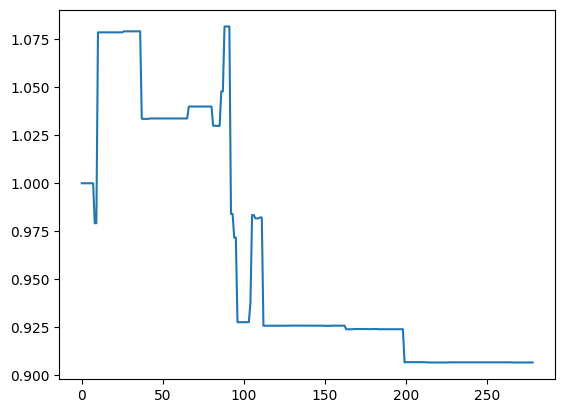

In [42]:
data = np.array(results['benchmark://cbench-v1/bitcount'])
plt.plot(data / data[0])
plt.show()

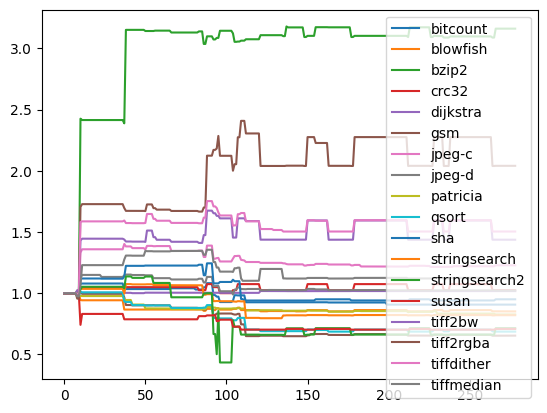

In [14]:
for name, data in results.items():
    if len(data) > 0:
        np_data = np.array(data)
        plt.plot(np_data / np_data[0], label=name)

plt.legend() 
plt.show()

In [17]:
results = {name: data for name, data in results.items() if len(data) > 0}

In [18]:
df = pd.DataFrame(data=results)

In [19]:
df

,bitcount,blowfish,bzip2,crc32,dijkstra,gsm,jpeg-c,jpeg-d,patricia,qsort,sha,stringsearch,stringsearch2,susan,tiff2bw,tiff2rgba,tiffdither,tiffmedian
0,581897,55313571,346834749,6251772,266615,144178612,24635476,7232856,666530,225227159,537438,579906,21055680,86694174,9327094,16422440,6886684,18198981
1,581897,55313571,346834749,6251772,266615,144178612,24635476,7232856,666530,225227159,537438,579906,21055680,86694174,9327094,16422440,6886684,18198981
2,581897,55313571,346834749,6251772,266615,144178612,24635476,7232856,666530,225227159,537438,579906,21055680,86694174,9327094,16422440,6886684,18198981
3,581897,55313571,346834749,6251772,266615,144178612,24635476,7232856,666530,225227159,537438,579906,21055680,86694174,9327094,16422440,6886684,18198981
4,581897,55313571,346834749,6251772,266615,144178612,24635476,7232856,666530,225227159,537438,579906,21055680,86694174,9327094,16422440,6886684,18198981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,527537,47072121,1096480003,6406178,271201,94179488,30248511,7385362,550771,154503448,510534,475635,15032734,61376172,13400838,33509344,10356135,20378879
275,527537,47072121,1096480003,6406178,271201,94179488,30248511,7385362,550771,154503448,510534,475635,15032734,61376172,13400838,33509344,10356135,20378879
276,527537,47072121,1096480003,6406178,271201,94179488,30248511,7385362,550771,154503448,510534,475635,15032734,61376172,13400838,33509344,10356135,20378879
277,527537,47072121,1096480003,6406178,271201,94179488,30248511,7385362,550771,154503448,510534,475635,15032734,61376172,13400838,33509344,10356135,20378879


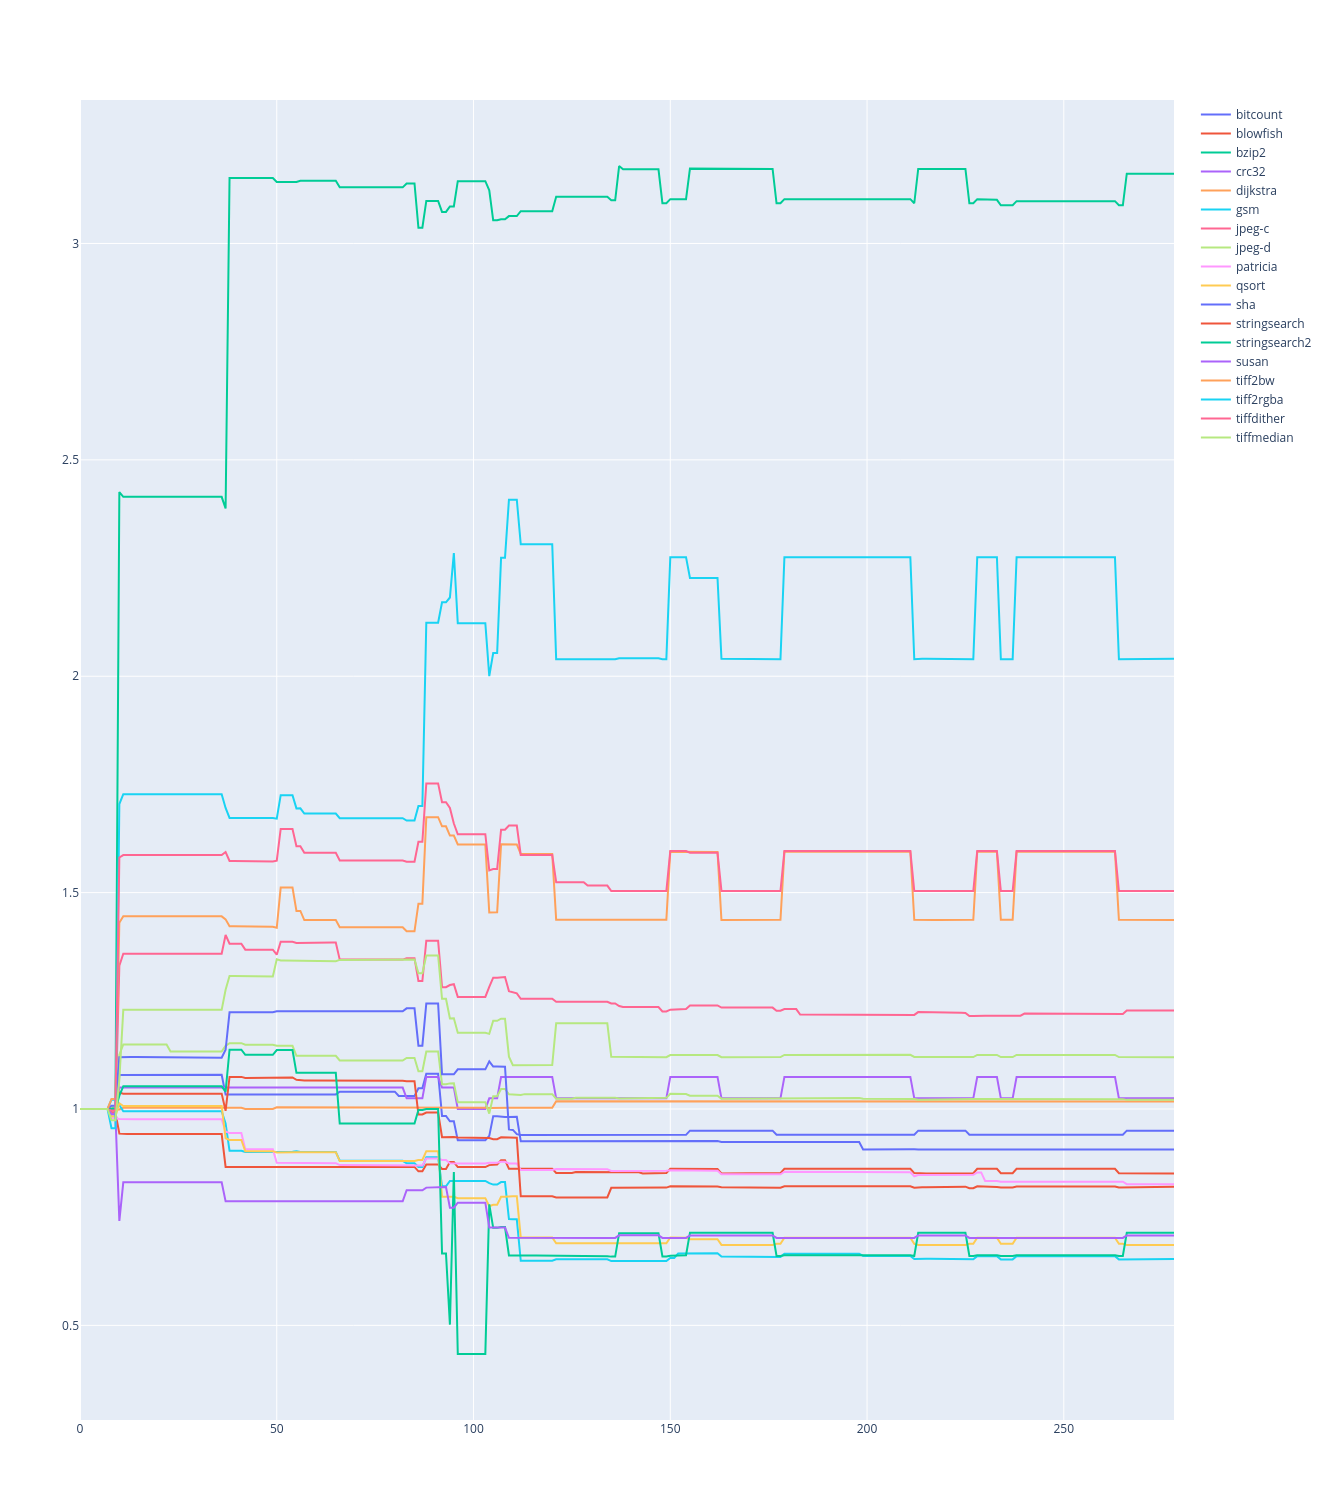

In [35]:
import plotly.graph_objects as go


fig = go.Figure()

for name, data in results.items():
    if len(data) > 0:
        np_data = np.array(data)
        fig.add_trace(go.Scatter(y=np_data / np_data[0],
                    mode='lines',
                    # mode='lines+markers',
                    name=name))
fig.update_layout(
    # width=1750, height=1000
    width=1750, height=1500
)
fig.show()